In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from aerobot.utils import RESULTS_PATH, DATA_PATH, FEATURE_TYPES, FIGURES_PATH
from aerobot.dataset import get_feature_order
from aerobot.plot import plot_configure_mpl, plot_color_palette
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks
from scipy.stats import linregress

plot_configure_mpl(figure_height=1.75)

In [2]:
earth_microbiome_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'aerobe_anaerobe_fraction.csv'))
black_sea_df = pd.read_csv(os.path.join(DATA_PATH, 'black_sea', 'black_sea.csv'))

# Figure 2

In [3]:
def plot_figure_2a(earth_microbiome_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Create a new axis in the grid.
    ax = fig.add_subplot(grid)
    # Convert fraction columns to percentages.
    for col in earth_microbiome_df.columns:
        if 'fraction' in col:
            earth_microbiome_df[col.replace('fraction', 'percent')] = earth_microbiome_df[col] * 100
    cols = ['habitat', 'anaerobe_percent', 'aerobe_percent', 'facultative_percent']
    earth_microbiome_df = earth_microbiome_df[(earth_microbiome_df.total > 240) & ~earth_microbiome_df.habitat.str.match('Host-associated')]
    earth_microbiome_df = earth_microbiome_df[cols].set_index('habitat').sort_values('anaerobe_percent', ascending=False)
    earth_microbiome_df.plot(kind='bar', stacked=True, ax=ax, legend=False, edgecolor='k', linewidth=0.5)
    ax.legend(['anaerobe', 'aerobe', 'facultative'], loc=3)
    # ax.legend(mean_fractions_df.prediction.unique(), loc=3)
    ax.set_ylabel('percent of MAGs in samples')
    ax.set_xlabel('')
    ax.set_xticks(np.arange(len(earth_microbiome_df.index)),
                  labels=earth_microbiome_df.index.values, 
                  fontsize=6, rotation=45, ha='right')
    ax.set_ylim(0, 100.1)
    ax.yaxis.set_major_formatter(ticks.PercentFormatter())

    return ax

In [4]:
def plot_figure_2b(black_sea_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Define a new sub-grid from the original grid. 
    sub_grid = GridSpecFromSubplotSpec(1, 2, wspace=0.2, hspace=0.1, subplot_spec=grid)
    ax_1 = fig.add_subplot(sub_grid[0, 0])
    ax_2 = fig.add_subplot(sub_grid[0, 1])

    ax_1.invert_yaxis()  # Invert the axis, so surface is at the top. 
    ax_2.invert_yaxis()  # Invert the axis, so surface is at the top. 
    ax_2.set_yscale('log') # Convert depth axis to logscale.
    ax_2.set_yticks([])
    ax_1.set_ylabel('depth (m)')
    
    ax_1.set_yscale('log')
    ax_1.set_xscale('log') # Convert x-axis to logscale.
    ax_1.set_xticks([1, 100], labels=[1, 100])
    ax_1.set_xlabel('conc. ($\mu$M)')
    
    kwargs = {'markersize':5, 'lw':0.75, 'markeredgecolor':'w', 'ls':'-', 'marker':'o',}
    ax_1.plot(black_sea_df.h2s_uM, black_sea_df.depth_m,  color=plot_color_palette()['yellow'], label='H$_2$S', **kwargs)
    ax_1.plot(black_sea_df.o2_uM, black_sea_df.depth_m, color=plot_color_palette()['red'],label='O$_2$', **kwargs)

    ax_2.set_xlabel('rel. abundance')
    ax_2.plot(black_sea_df['aerobe'], black_sea_df.depth_m, color=plot_color_palette()['green'], label='aerobe', **kwargs)
    ax_2.plot(black_sea_df['anaerobe'], black_sea_df.depth_m, color=plot_color_palette()['purple'], label='anaerobe', **kwargs)

    return ax_1

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_89360/1004630583.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax_1.set_xlabel('conc. ($\mu$M)')


In [5]:
def plot_figure_2c(black_sea_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Create an axis in the specified grid space.
    ax = fig.add_subplot(grid)

    # Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
    o2_h2s_ratio = black_sea_df.o2_uM / black_sea_df.h2s_uM
    aerobe_anaerobe_ratio = black_sea_df.aerobe / black_sea_df.anaerobe

    # Perform linear regression on the log-transformed data. 
    log_o2_h2s_ratio = np.log10(o2_h2s_ratio)
    log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

    # Do linear regression on the log ratios.
    reg = linregress(log_aerobe_anaerobe_ratio, log_o2_h2s_ratio)
    print('Regression results:', reg)
    x_vals = np.logspace(log_aerobe_anaerobe_ratio.min(), log_aerobe_anaerobe_ratio.max(), 100)
    y_vals = reg.intercept + reg.slope * np.log10(x_vals)

    ax.loglog(aerobe_anaerobe_ratio.values, o2_h2s_ratio.values, marker='o',
              markersize=5, ls='', markeredgewidth=0.5, color='gray',
              markerfacecolor='w', markeredgecolor='k', zorder=10)
    ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=0)

    # Bootstrap a confidence interval plot manually because seaborns regplot doesn't handle log scale...
    for _ in range(1000):
        slope = np.random.normal(reg.slope, reg.stderr)
        intercept = np.random.normal(reg.intercept, reg.intercept_stderr)
        y_vals = intercept + slope * np.log10(x_vals)
        ax.plot(x_vals, 10**y_vals, color=plot_color_palette()['blue'], ls='-', lw=0.5, zorder=-10)

    ax.set_xlabel('inferred aerobe/anaerobe ratio')
    ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
    ax.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-5}}$'.format(reg.rvalue, reg.pvalue), transform=ax.transAxes, ha='right', va='bottom')
    return ax

Regression results: LinregressResult(slope=1.6479758016891264, intercept=-0.5035456976059252, rvalue=0.972988848172145, pvalue=1.1755477333639586e-09, stderr=0.10844390773956794, intercept_stderr=0.11064018454598602)


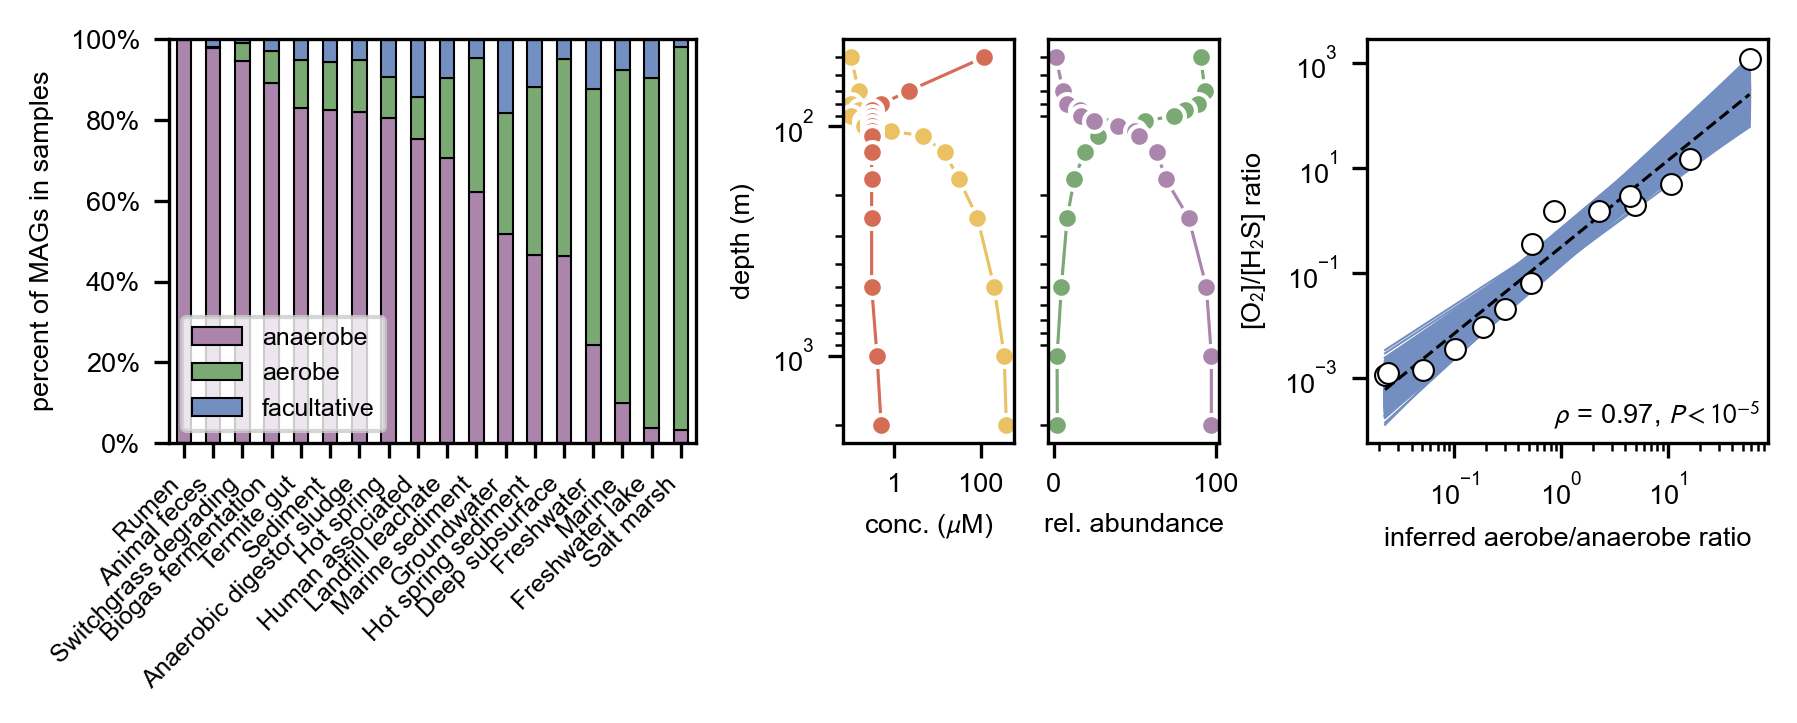

In [6]:
fig = plt.figure()
grid = GridSpec(1, 3, width_ratios=(2.1, 1.5, 1.6), wspace=0.34, hspace=0.4)

axes = []
axes.append(plot_figure_2a(earth_microbiome_df, grid=grid[0], fig=fig))
axes.append(plot_figure_2b(black_sea_df, grid=grid[1], fig=fig))
axes.append(plot_figure_2c(black_sea_df, grid=grid[2], fig=fig))


plt.savefig(os.path.join(FIGURES_PATH, 'fig2.png'), dpi=300, facecolor='w', bbox_inches='tight')
plt.show()


In [12]:

# Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
o2_h2s_ratio = black_sea_df.o2_uM / black_sea_df.h2s_uM
aerobe_anaerobe_ratio = black_sea_df.aerobe / black_sea_df.anaerobe

# print(np.all(o2_h2s_ratio > 0))
# print(np.all(aerobe_anaerobe_ratio > 0))

# Perform linear regression on the log-transformed data. 
x_vals = np.log10(o2_h2s_ratio)
y_true = np.log10(aerobe_anaerobe_ratio)

# Do linear regression on the log ratios.
reg = linregress(x_vals, y_true)
y_pred = reg.intercept + reg.slope * np.log10(x_vals)

y_true, y_pred = np.power(10, y_true), np.power(10, y_pred)
err = np.mean(np.abs(y_pred - y_true)/y_true)
print('Multiplicative error:', err)



Multiplicative error: 0.7196301618902604


In [8]:
mask = earth_microbiome_df.habitat.isin(['Rumen', 'Animal feces', 'Anaerobic digestor sludge', 'Marine', 'Freshwater lake'])
earth_microbiome_df[mask][earth_microbiome_df.columns[4:10]]

,anaerobe,aerobe,facultative,total,habitat,aerobe_anaerobe_ratio
6,1358.0,211.0,87.0,1656,Anaerobic digestor sludge,0.155376
8,6441.0,16.0,129.0,6586,Animal feces,0.002484
48,16.0,360.0,40.0,416,Freshwater lake,22.500000
77,261.0,2172.0,200.0,2633,Marine,8.321839
94,606.0,0.0,0.0,606,Rumen,0.000000


In [9]:
black_sea_df

,Unnamed: 0,aerobe,anaerobe,facultative,depth_m,o2_uM,h2s_uM
0,SRR12347146,90.444193,1.554113,8.001694,50.0,121.2,0.10
1,SRR12347145,93.298326,5.752589,0.949085,70.0,2.2,0.15
2,SRR12347139,89.186633,8.294893,2.518474,80.0,0.5,0.10
3,SRR12347138,80.663516,16.334816,3.001668,85.0,0.3,0.15
4,SRR12347137,73.841095,16.784769,9.374136,90.0,0.3,0.10
5,SRR12347136,56.420212,24.983408,18.596380,95.0,0.3,0.20
6,SRR12347135,33.925030,39.861342,26.213627,100.0,0.3,0.20
7,SRR12347134,26.875694,50.202991,22.921315,105.0,0.3,0.85
8,SRR12347133,27.579125,52.340430,20.080445,110.0,0.3,4.60
9,SRR12347132,19.084945,63.858131,17.056925,130.0,0.3,14.65


Regression results: LinregressResult(slope=1.6479758016891264, intercept=-0.5035456976059252, rvalue=0.972988848172145, pvalue=1.1755477333639586e-09, stderr=0.10844390773956794, intercept_stderr=0.11064018454598602)
Regression results: LinregressResult(slope=1.7346991169265684, intercept=-0.756440170355634, rvalue=0.9686347132561052, pvalue=3.0730567241202644e-09, stderr=0.12342401013591202, intercept_stderr=0.1184142969809944)


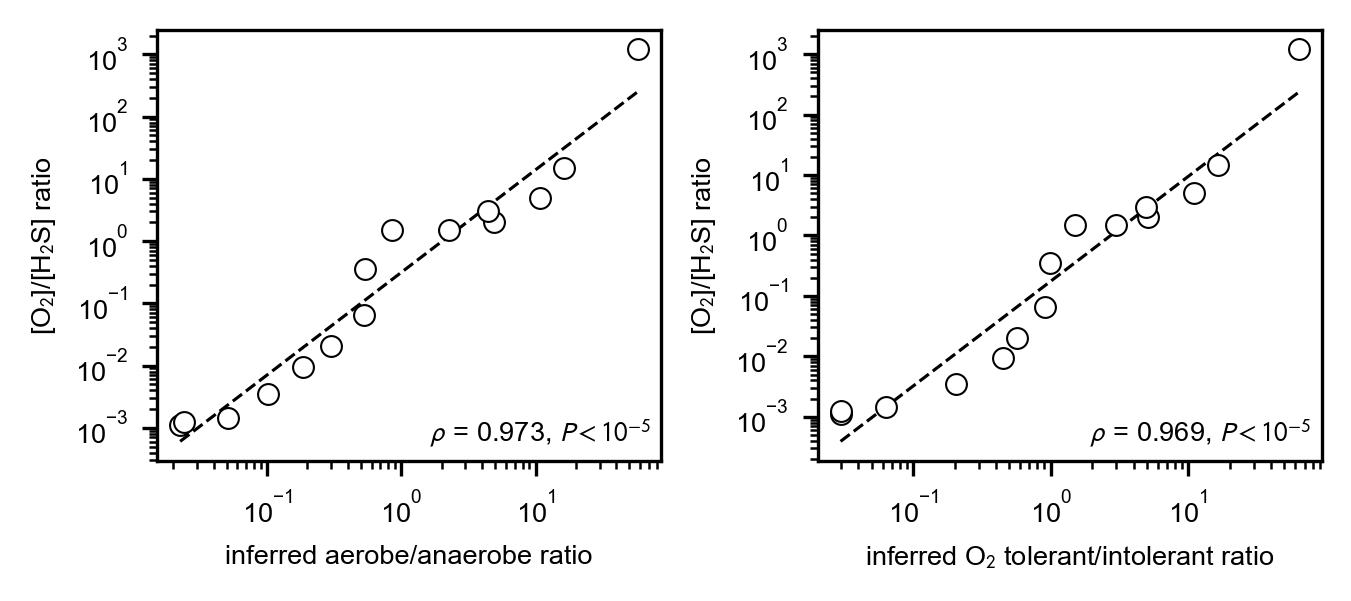

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 2))

# Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
o2_h2s_ratio = black_sea_df.o2_uM / black_sea_df.h2s_uM
aerobe_anaerobe_ratio = black_sea_df.aerobe / black_sea_df.anaerobe
tolerant_ratio = (black_sea_df.aerobe+black_sea_df.facultative) / black_sea_df.anaerobe

# Perform linear regression on the log-transformed data. 
log_o2_h2s_ratio = np.log10(o2_h2s_ratio)
log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)
log_tolerant_ratio = np.log10(tolerant_ratio)

ax = axs[0]
# Do linear regression on the log aerobe/anaerobe ratio.
reg = linregress(log_aerobe_anaerobe_ratio, log_o2_h2s_ratio)
print('Regression results:', reg)
x_vals = np.logspace(log_aerobe_anaerobe_ratio.min(), log_aerobe_anaerobe_ratio.max(), 100)
y_vals = reg.intercept + reg.slope * np.log10(x_vals)

ax.loglog(aerobe_anaerobe_ratio.values, o2_h2s_ratio.values, marker='o',
          markersize=5, ls='', markeredgewidth=0.5, color='gray',
          markerfacecolor='w', markeredgecolor='k', zorder=10)
ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=0)
ax.set_xlabel('inferred aerobe/anaerobe ratio')
ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
ax.text(0.98, 0.03, '$\\rho$ = {0:.3f}, $P < 10^{{-5}}$'.format(reg.rvalue, reg.pvalue),
        transform=ax.transAxes, ha='right', va='bottom')

ax = axs[1]
# Do linear regression on the log tolerant/intolerant ratio.
reg = linregress(log_tolerant_ratio, log_o2_h2s_ratio)
print('Regression results:', reg)
x_vals = np.logspace(log_tolerant_ratio.min(), log_tolerant_ratio.max(), 100)
y_vals = reg.intercept + reg.slope * np.log10(x_vals)

ax.loglog(tolerant_ratio.values, o2_h2s_ratio.values, marker='o',
          markersize=5, ls='', markeredgewidth=0.5, color='gray',
          markerfacecolor='w', markeredgecolor='k', zorder=10)
ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=0)
ax.set_xlabel('inferred O$_2$ tolerant/intolerant ratio')
ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
ax.text(0.98, 0.03, '$\\rho$ = {0:.3f}, $P < 10^{{-5}}$'.format(reg.rvalue, reg.pvalue),
        transform=ax.transAxes, ha='right', va='bottom')

plt.tight_layout()
plt.show()